# $x^4$ Approximation 

### __Theory:__
The problem revolves around solving the Schrödinger Equation for $x^4$ perturbation:

$$ \left(\frac{1}{2m}\hat{p}^2 + \frac{1}{2}k\hat{x}^2 + \lambda x^4\right)\ket{\psi} = E\ket{\psi} \iff (\hat{H}_\text{osc} + \lambda \hat{x}^4)\ket{\psi} = E\ket{\psi}$$

We will solve this equation for the ground state, which means finding the lowest eigenvalue $E$ and its corresponding eigenstate $\ket{\psi}$.

Since the eigenstates of the QHO $\,\,\{\ket{n}\}_{n=1}^\infty\,\,$  form a basis for $L^2(\mathbb{C})$, we can assume that the groundstate takes the form:

$$\ket{\psi_0} = \sum_{n = 0}^\infty \alpha _n \ket{n} \qquad \alpha_i \in \mathbb{C}$$

which reduces the problem to that of finding the coefficients $\{\alpha_i\}_{i = 0}^\infty \,\,$. This can be presented as an optimization problem: It can be shown that $$E_0 = \bra{\psi_0}\hat{H}\ket{\psi_0} \leq \bra{\psi_\Theta}\hat{H}\ket{\psi_\Theta}$$ where $\psi_\Theta$ is a state perturbed away from $\psi_0$. Thus, the loss functional $\mathfrak{L}$ that we will try to minimize such that $\ket{\psi_\Theta}$ approaches $\ket{\psi_0}$ is simply given by $$\mathfrak{L}(\ket{\psi_\Theta}) = \bra{\psi_\Theta}\hat{H}\ket{\psi_\Theta}$$. 

### __Approach:__
We will use pytorch to solve this problem. First, we will define a truncation parameter $N$ to turn the infinite representation of $\ket{\psi}$ into a finite approximate representation. The problem reduces to findining:
$$\boldsymbol{\hat{\alpha}} \coloneqq 
\underset{\alpha }{\arg\min} |\sum_{i,\, j = 0}^N \bar{\alpha}_i \alpha_j\bra{i}\hat{H}\ket{j}|$$

Given that this is now a finite dimensional problem, we can represent $\hat{H}$ as a matrix $H \eqqcolon [\hat{H}]_\mathfrak{B}$ (with respect to the basis $\mathfrak{B}=\{\ket{0}, \ket{1},...\ket{N}\}$ ), with its components given by $H_{nm} = \bra{n}\hat{H}\ket{m}$. In this representation, 
$\sum_{n=0}^N \alpha_n \ket{n} = \boldsymbol{\alpha}$ and thus 
$$\boldsymbol{\hat{\alpha}} = \underset{\alpha }{\arg\min}|\boldsymbol{\alpha}^\dagger H \alpha|$$

We can see that $[\hat{H}_\text{osc}]_\mathfrak{B} = \text{Diag}(e_0, e_1, ..., e_N)$ with $e_n = (\frac{1}{2}+n)h\omega$ as the basis elements are eigenstates of the operator. The representation of $\hat{x}$ is not as obvious, but decomposing it into the ladder operators as $\hat{x} = \frac{1}{\sqrt{2}}(\hat{a}^\dagger + \hat{a})$, we have:
$$[\hat{x}]_\mathfrak{B} = \frac{1}{\sqrt{2}}
\begin{pmatrix}
    0 & \sqrt{1} & 0 & 0 & \dots\\
    \sqrt{1}& 0 & \sqrt{2} & 0 &\dots\\
    0& \sqrt{2}&0&\sqrt{3}\\
    0&0&\sqrt{3}&0\\
    \dots&&&&{\dots}\\
    &&&&&\sqrt{N}\\ 
    &&&&\sqrt{N}&0\\
\end{pmatrix}
$$

Therefore, we are able to compute the coefficients by calculating the loss explicitely using the QHO basis representation for matrices and vectors. 

In [167]:
import torch
import math
import matplotlib.pyplot as plt
%matplotlib inline

# hyperparameters
w = 1
h = 1
lmbda = 0.25
N = 50
lr = 1e-3
epochs = 40000

hyperparams = {'lmbda': lmbda, 'lr': lr, 'epochs': epochs}

device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)
    

Using device cpu


We proceed to define the different tensors as outlined in the 'Theory' section, being careful to specify the vectors that are meant to have a gradient.

In [168]:
coeffs = torch.rand(N+1, dtype=torch.cfloat, requires_grad=True)
normed_coeffs = coeffs/torch.norm(coeffs)
coeffs_conj = torch.conj(normed_coeffs)
H_osc = torch.diag((torch.arange(N+1)+0.5)*h*w+0j)
x  = torch.zeros(N+1, N+1, requires_grad=False, dtype=torch.cfloat)
for i in range(N):
    n = i+1
    x[n][i] = math.sqrt(n/2)
    x[i][n] = math.sqrt(n/2)

# print(f'H matrix:\n {H_osc}\n')
# print(f'x matrix:\n {x}\n')
# print(f'alpha:\n {normed_coeffs}\n')
# print(f'alpha conjugated:\n {coeffs_conj}\n')
# print(f'Normalized? -> norm: {coeffs_conj@normed_coeffs}')

We then define the loss function $\mathfrak{L}$ as `x4loss`, along with an `optimize` function to optimize the coefficients. `optimize` will return data points for plotting the loss vs the number of iterations.

_Note:_ the `x4loss` is a pure function, while optimize is not. This is made for simplicity in this scenario, as there is not much room for ambiguity with respect to the loss function. A more robust scenario would include the loss function as an argument, along with any arguments the loss function requires, but will be avoided in this situation for better readibility.

In [170]:
def x4loss(alpha, Hosc, x, lmbda):
    normed_alpha = alpha/torch.norm(alpha)
    alpha_conj = torch.conj(normed_alpha)
    return torch.abs(alpha_conj@(Hosc + lmbda*x@x@x@x)@normed_alpha)

def optimize(alpha, x, H_osc, **hyperparams):
    lr = hyperparams['lr']
    epochs = hyperparams['epochs']
    lmbda = hyperparams['lmbda']
    interv = 50
    optimizing_info = torch.zeros(epochs//interv, 2)
    optimizer = torch.optim.Adam([alpha], lr=lr)
    for step in range(epochs):
        loss = x4loss(coeffs, H_osc, x, lmbda)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if not step%interv:
            print(f'step: {step} \n\nloss: {loss}')
            optimizing_info[step//interv][0] = step
            optimizing_info[step//interv][1] = loss
    return optimizing_info
plot_data = optimize(coeffs, x, H_osc, **hyperparams).detach()


step: 0 

loss: 0.6941936612129211
step: 50 

loss: 0.6851170659065247
step: 100 

loss: 0.6776711940765381
step: 150 

loss: 0.6713687181472778
step: 200 

loss: 0.6659184694290161
step: 250 

loss: 0.6611543893814087
step: 300 

loss: 0.6569592952728271
step: 350 

loss: 0.6532407999038696
step: 400 

loss: 0.6499248147010803
step: 450 

loss: 0.6469520330429077
step: 500 

loss: 0.6442756652832031
step: 550 

loss: 0.6418589353561401
step: 600 

loss: 0.6396728157997131
step: 650 

loss: 0.637692928314209
step: 700 

loss: 0.6358990669250488
step: 750 

loss: 0.6342742443084717
step: 800 

loss: 0.6328034400939941
step: 850 

loss: 0.631473183631897
step: 900 

loss: 0.630271315574646
step: 950 

loss: 0.6291874647140503
step: 1000 

loss: 0.628211259841919
step: 1050 

loss: 0.627332866191864
step: 1100 

loss: 0.6265453100204468
step: 1150 

loss: 0.6258437633514404
step: 1200 

loss: 0.6252105236053467
step: 1250 

loss: 0.6246490478515625
step: 1300 

loss: 0.6241504549980164
st

We can see that after roughly $10 000$ iterations, the loss stabilizes around a value $y\approx0.62092$ for $\lambda = 0.25$, which would imply that this is the ground state energy of the system. 

We will proceed to plot the values for the Loss along with this inferred lower bound for the loss.

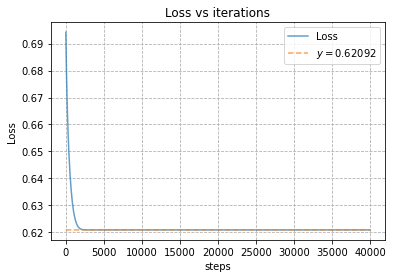

In [171]:
plt.plot(plot_data[:,0], plot_data[:, 1], label='Loss', alpha=0.7)
plt.plot(torch.arange(0, epochs), [0.62092]*epochs, ls='--', alpha=0.7, 
         label=r'$y=0.62092$')
plt.title('Loss vs iterations')
plt.xlabel('steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(ls='--')

We can see that the Loss function stabilized around step $10000$ indeed, suggesting the ground energy has been reached (or a local minimum for the Loss function), and it is equal to the aforementioned $y$. 

To analyze the eigenstate, we just need to analyze the coefficients that were optimized. They are shown below, both printed out and in a diagram. 

_Remark:_ The even terms of the basis appear to have a significant distribution, while the odd terms are orders of magnitude smaller than the even terms.

tensor([ 7.3236e-01+6.6915e-01j,  8.7866e-12-4.3475e-11j,
        -9.2765e-02-8.4758e-02j,  1.0216e-11-5.0547e-11j,
         1.4402e-03+1.3163e-03j,  1.2537e-11-6.2033e-11j,
         6.4689e-03+5.9110e-03j,  1.5896e-11-7.8648e-11j,
        -3.2928e-03-3.0082e-03j,  2.0368e-11-1.0077e-10j,
         9.5349e-04+8.7153e-04j,  2.5985e-11-1.2857e-10j,
        -6.9716e-05-6.3428e-05j,  3.2700e-11-1.6179e-10j,
        -1.1793e-04-1.0756e-04j,  4.0371e-11-1.9975e-10j,
         9.3521e-05+8.5554e-05j,  4.8774e-11-2.4132e-10j,
        -4.3397e-05-3.9628e-05j,  5.7619e-11-2.8509e-10j,
         1.2493e-05+1.1371e-05j,  6.6589e-11-3.2947e-10j,
         6.7719e-08-2.7840e-08j,  7.5361e-11-3.7287e-10j,
        -2.9497e-06-2.8052e-06j,  8.3648e-11-4.1387e-10j,
         2.4077e-06+2.0904e-06j,  9.1216e-11-4.5132e-10j,
        -1.2480e-06-1.2349e-06j,  9.7903e-11-4.8440e-10j,
         4.6109e-07+3.5307e-07j,  1.0362e-10-5.1271e-10j,
        -5.7190e-08-8.6242e-08j,  1.0837e-10-5.3621e-10j,
        -7.304

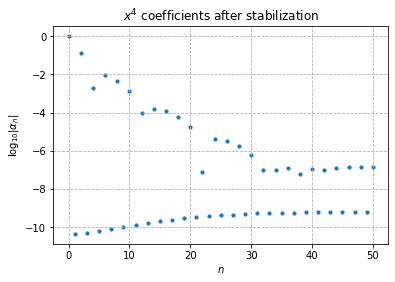

In [172]:
normed_coeffs = coeffs/torch.norm(coeffs)
print(normed_coeffs)
epsi = 1e-13  # to avoid evaluating log(0)
plt.scatter(torch.arange(0, N+1), torch.log10(torch.abs(normed_coeffs).detach()+epsi), s=10)
plt.title(r'$x^4$ coefficients after stabilization')
plt.xlabel(r'$n$')
plt.ylabel(r'$\log_{10}|\alpha_n|$')
plt.grid(ls='--')